## Long Short-Term Memory

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


In [3]:
TRAIN = "train/"
TEST = "test/"
DATASET_PATH = "C:/Users/Sinyoung/Documents/GitHub/Analyzing_HAR_data/Data/"

# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


In [24]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 25  # Loop 300 times on the dataset
batch_size = 500
display_iter = 3000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [25]:
def LSTM_RNN(_X, _weights, _biases):

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

tf.disable_v2_behavior()

graph = tf.Graph()
with graph.as_default():
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    # Graph weights
    weights = {
        'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([n_hidden])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    pred = LSTM_RNN(x, weights, biases)
    
    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


C:\Users\Sinyoung\AppData\Local\Temp\ipykernel_13320\1293351181.py:15: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
C:\Users\Sinyoung\AppData\Local\Temp\ipykernel_13320\1293351181.py:16: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)


In [26]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=graph)
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train[::10], step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train[::10], step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test[::10],
                y: one_hot(y_test[::10])
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test[::10],
        y: one_hot(y_test[::10])
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Device mapping: no known devices.


C:\Users\Sinyoung\anaconda3\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training iter #500:   Batch Loss = 2.926100, Accuracy = 0.11599999666213989
PERFORMANCE ON TEST SET: Batch Loss = 2.4990148544311523, Accuracy = 0.37966102361679077
Training iter #3000:   Batch Loss = 1.754999, Accuracy = 0.5299999713897705
PERFORMANCE ON TEST SET: Batch Loss = 1.7542496919631958, Accuracy = 0.5898305177688599
Training iter #6000:   Batch Loss = 1.338413, Accuracy = 0.7039999961853027
PERFORMANCE ON TEST SET: Batch Loss = 1.4461452960968018, Accuracy = 0.6237288117408752
Training iter #9000:   Batch Loss = 1.213188, Accuracy = 0.7459999918937683
PERFORMANCE ON TEST SET: Batch Loss = 1.453538417816162, Accuracy = 0.6508474349975586
Training iter #12000:   Batch Loss = 1.168008, Accuracy = 0.7699999809265137
PERFORMANCE ON TEST SET: Batch Loss = 1.3438570499420166, Accuracy = 0.694915235042572
Training iter #15000:   Batch Loss = 1.099565, Accuracy = 0.7960000038146973
PERFORMANCE ON TEST SET: Batch Loss = 1.303466796875, Accuracy = 0.7288135886192322
Training iter #1800

Training iter #150000:   Batch Loss = 0.517395, Accuracy = 0.9679999947547913
PERFORMANCE ON TEST SET: Batch Loss = 1.0373001098632812, Accuracy = 0.8644067645072937
Training iter #153000:   Batch Loss = 0.526251, Accuracy = 0.972000002861023
PERFORMANCE ON TEST SET: Batch Loss = 0.9959759712219238, Accuracy = 0.8644067645072937
Training iter #156000:   Batch Loss = 0.548073, Accuracy = 0.9539999961853027
PERFORMANCE ON TEST SET: Batch Loss = 0.9980436563491821, Accuracy = 0.8677965998649597
Training iter #159000:   Batch Loss = 0.531218, Accuracy = 0.9580000042915344
PERFORMANCE ON TEST SET: Batch Loss = 0.9845640659332275, Accuracy = 0.8779661059379578
Training iter #162000:   Batch Loss = 0.512090, Accuracy = 0.9620000123977661
PERFORMANCE ON TEST SET: Batch Loss = 0.9684422016143799, Accuracy = 0.8745762705802917
Training iter #165000:   Batch Loss = 0.518029, Accuracy = 0.9520000219345093
PERFORMANCE ON TEST SET: Batch Loss = 0.991930365562439, Accuracy = 0.8576270937919617
Traini

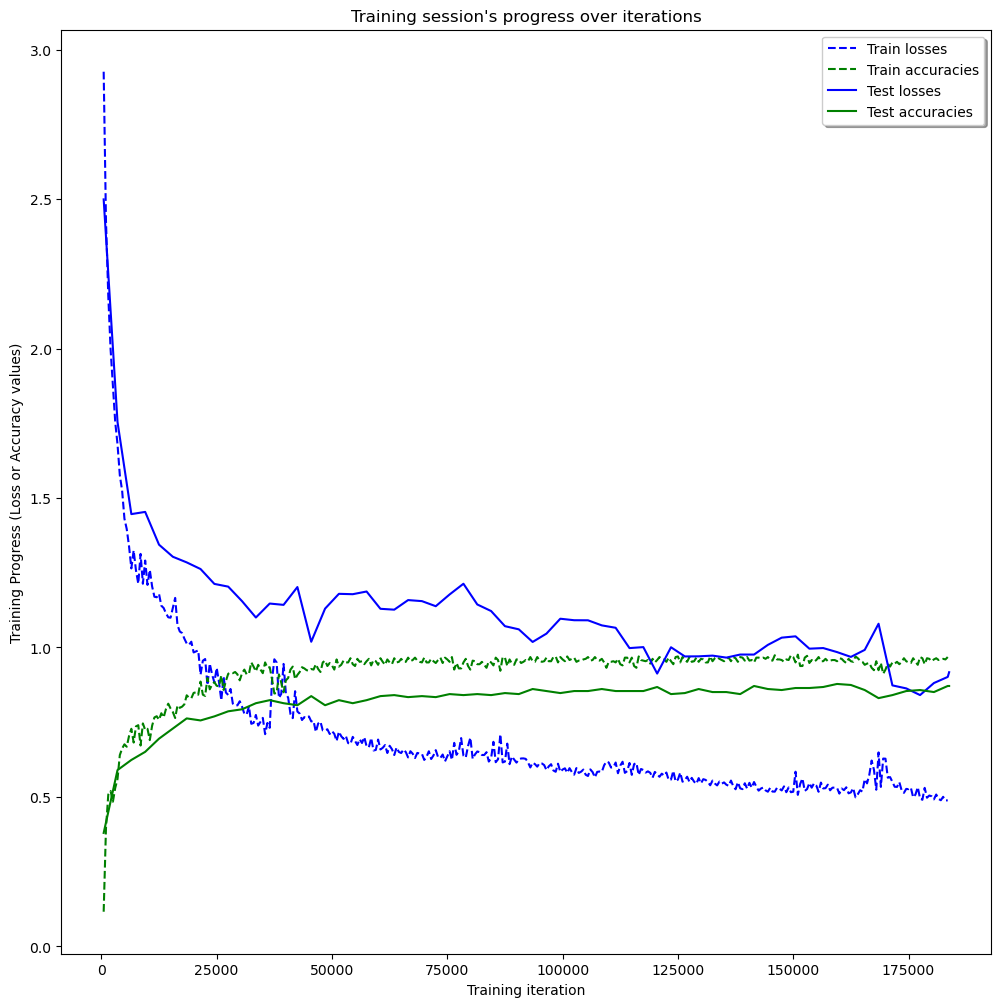

In [27]:
width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 87.11864352226257%

Precision: 87.41811125525516%
Recall: 87.11864406779661%
f1_score: 87.09966678806211%

Confusion Matrix:
[[47  1  2  0  0  0]
 [ 5 39  4  0  0  0]
 [ 7  1 36  0  0  0]
 [ 0  3  0 42  6  0]
 [ 1  0  0  8 41  0]
 [ 0  0  0  0  0 52]]


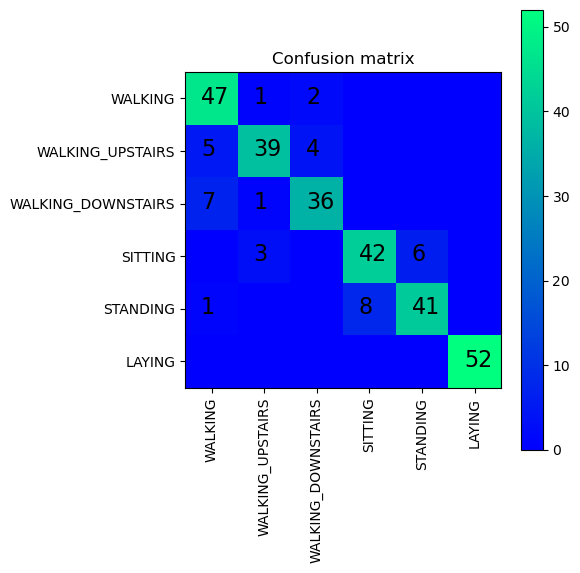

In [28]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test[::10], predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test[::10], predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test[::10], predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test[::10], predictions)
print(confusion_matrix)

# Plot Results: 
width = 6
height = 6
plt.figure(figsize=(width, height))
plt.imshow(
    confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.winter
)
for i, row in enumerate(confusion_matrix):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
plt.show()